<a href="https://colab.research.google.com/github/bhuvanmdev/basic_symmetric_crypto/blob/main/train_your_own_cnn_model(beta).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown tick the box below if you want detailed summary of the
#@markdown process, else ignore it and run all
Detailed_results = True #@param{type:"boolean"}

*Install all required modules in a single go*

In [7]:
!pip install mediapipe opencv-python tensorflow numpy pandas matplotlib seaborn > /dev/null 2>&1

**UNZIP THE IMAGES**

In [9]:
#@markdown name variable refers to the imported zip name
name = "ar" #@param {allow-input: true}
!unzip -q {name}.zip

**IMPORT ALL REQUIRED MODULES**

In [10]:
#@title Default title text
import mediapipe as mp
import cv2 as cv
import csv
import os
import copy,itertools

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


RANDOM_SEED = 42

**All the paths of files/images and modules**

In [17]:
#@title Default title text
model_save_path = 'keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier.tflite'
csv_path = name+'.csv'
image_folder = r"data"

**Converts images-->hand_labels in csv format**

In [18]:
#@title .
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.7)


def calc_landmark_list(image, landmarks):
    image_height_y,image_width_x,_  = image.shape

    landmark_point = []

    # Keypoint
    for landmark in landmarks.landmark: # 21/42  loops for learning 1/2 hands
        landmark_x = min(int(landmark.x * image_width_x), image_width_x - 1)
        landmark_y = min(int(landmark.y * image_height_y), image_height_y - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates(having a x=0 and y=0)
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))#convert them from 0-1 range

    return temp_landmark_list

def logging_csv(number,landmark_list):
    with open(csv_path, 'a', newline="") as f:
        writer = csv.writer(f)
        writer.writerow([number, *landmark_list])




labels = []
number = 0
# os.chdir(os.listdir(image_folder)[0])
for number,files in enumerate(sorted(os.listdir(image_folder))):
    for img in os.listdir(os.path.join(image_folder,files)):
        img_path = os.path.join(image_folder,files,img)
        image = cv.imread(img_path)
        image_bgr = cv.cvtColor(image,cv.COLOR_BGR2RGB)
        results = hands.process(image_bgr)
        if results.multi_hand_landmarks is not None:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks,
                                                  results.multi_handedness):

                landmark_list = calc_landmark_list(image, hand_landmarks)

                # Conversion to relative coordinates / normalized coordinates
                pre_processed_landmark_list = pre_process_landmark(
                    landmark_list)
#
                # Write to the dataset file
                logging_csv(number, pre_processed_landmark_list)
NUM_CLASSES = number+1

**LOAD THE DATASETS FROM THE CSV FILE INTO *test* and *train* set**

In [19]:
X_dataset = np.loadtxt(csv_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(csv_path, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED) # you can change the train_size between 0.75-0.85 for good efficieny

**MODEL CONSTRUCTION**

In [20]:
model = tf.keras.models.Sequential([
    Input((21 * 2,)),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])
#100 images per class is a minimum

**MODEL SUMMARY**

In [21]:
if Detailed_results:
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 10)                430       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
 dense_3 (Dense)             (None, 2)                 8

**IMPORTANT CALLBACKS**

In [22]:
# Callback to save the progress at intervals of time
display(cp_callback := tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False))
# Callback for early stopping to avoid overfitting
display(es_callback := tf.keras.callbacks.EarlyStopping(patience=20, verbose=1))

**COMPILE THE MODEL WITH REQUIRED SETTINGS**

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**MODEL TRAINING**

In [25]:
model.fit(
    X_train,
    y_train,
    #@markdown you can change these values based on the amount of classes present
    epochs=30#@param
    ,
    batch_size=5#@param
    ,validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/30
31/41 [=====================>........] - ETA: 0s - loss: 0.5179 - accuracy: 0.7742
Epoch 1: saving model to keypoint_classifier.hdf5
41/41 [==============================] - 0s 4ms/step - loss: 0.5167 - accuracy: 0.7610 - val_loss: 0.3833 - val_accuracy: 0.9855
Epoch 2/30
38/41 [==========================>...] - ETA: 0s - loss: 0.4974 - accuracy: 0.7789
Epoch 2: saving model to keypoint_classifier.hdf5
41/41 [==============================] - 0s 6ms/step - loss: 0.4999 - accuracy: 0.7756 - val_loss: 0.3500 - val_accuracy: 0.9855
Epoch 3/30
35/41 [========================>.....] - ETA: 0s - loss: 0.4745 - accuracy: 0.8171
Epoch 3: saving model to keypoint_classifier.hdf5
41/41 [==============================] - 0s 7ms/step - loss: 0.4800 - accuracy: 0.7951 - val_loss: 0.3332 - val_accuracy: 0.9855
Epoch 4/30
37/41 [==========================>...] - ETA: 0s - loss: 0.4788 - accuracy: 0.8108
Epoch 4: saving model to keypoint_classifier.hdf5
41/41 [==============================

**shows us the final accuracy of the model**

In [26]:
if Detailed_results:
  val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64
                                    )
  # Loading the saved model
  model = tf.keras.models.load_model(model_save_path)

# Inference test
# predict_result = model.predict(np.array([X_test[0]]))
# print(np.squeeze(predict_result))
# print(np.argmax(np.squeeze(predict_result)))

2/2 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 1.0000


**CONFUSION MATRIX**(grahical and tabular representation of loss & accuracy)

3/3 [==============================] - 0s 3ms/step


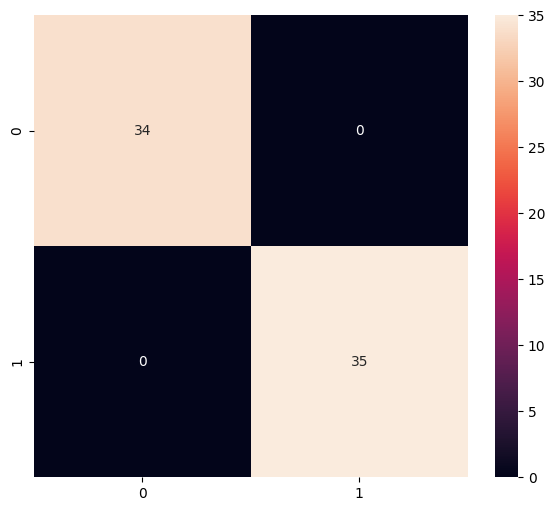

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [27]:

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

if Detailed_results:
  Y_pred = model.predict(X_test)
  y_pred = np.argmax(Y_pred, axis=1)

  print_confusion_matrix(y_test, y_pred)

**saves the model as .tflite file in the specified path**

In [28]:
model.save(model_save_path, include_optimizer=False)
[35]
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

**INFERENCE TEST**

In [30]:
if Detailed_results:
  interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
  interpreter.allocate_tensors()

  # Get I / O tensor
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))


  # Inference implementation
  interpreter.invoke()
  tflite_results = interpreter.get_tensor(output_details[0]['index'])


  print(np.squeeze(tflite_results))
  print(np.argmax(np.squeeze(tflite_results)))

[0.99075294 0.00924709]
0


In [5]:
# unzip compressed.zip

# !zip -rq9 archive.zip mohith

# !Compress-Archive -Path 'directory' -DestinationPath 'archive.zip'

#labels should b written in lexographical order!
